# Covid in NJ

In [1]:
import cmocean.cm as cmo
import folium
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Video
from matplotlib.colors import rgb2hex
from pyinla.model import *
from pyinla.raster import *
from pyinla.spde import *
from pyinla.utils import *
from tqdm.auto import tqdm

In [45]:
df = pd.read_csv("./data/jersey_covid_2021-2022.csv")
df = df[df.date.apply(lambda x: "2021" in x).values]
population = pd.read_csv("./data/njpop.csv")
income = pd.read_csv("./data/njincome.csv")
pov = pd.read_csv("./data/njpoverty.csv")

In [46]:
geojson = gpd.read_file("./data/nj_county_boundaries.geojson")
geojson = geojson[["geometry", "COUNTY", "FIPSSTCO"]]
geojson["fips"] = geojson["FIPSSTCO"].astype(int)
geojson = geojson.drop("FIPSSTCO", axis=1)
gdf = (
    geojson.merge(population, on="COUNTY")
    .merge(income, on="COUNTY")
    .merge(pov, on=["COUNTY", "fips"])
    .merge(df, on="fips")
)

In [47]:
gdf["death_frac"] = gdf.deaths / gdf.cases

<AxesSubplot: >

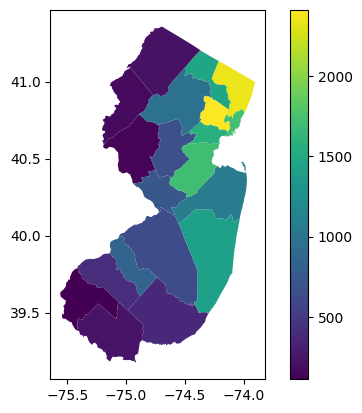

In [5]:
gdf[gdf.date == "2021-01-05"].plot("deaths", legend=True)

In [48]:
for i in range(1, len(gdf)):
    diff = gdf["cases"][i] - gdf["cases"][i - 1]
    if diff < 0:
        gdf.loc[i:, "cases"] = gdf.loc[i:, "cases"] + np.abs(diff)
    diff = gdf["deaths"][i] - gdf["deaths"][i - 1]
    if diff < 0:
        gdf.loc[i:, "deaths"] = gdf.loc[i:, "deaths"] + np.abs(diff)

In [49]:
d = gdf.date[0]

In [155]:
for i, d in tqdm(enumerate(np.unique(gdf.date))):
    ax = gdf[gdf.date == d].plot(
        "death_frac",
        cmap=cmo.deep,
        legend=1,
        vmin=0.0,
        vmax=0.06,
        norm=plt.Normalize(vmin=0.0, vmax=0.06),
    )
    ax.axis("off")
    ax.set_title(d)
    fig = ax.get_figure()
    fig.savefig(f"./out/njdf-{str(i).zfill(3)}.jpg", dpi=300)
    plt.close()

0it [00:00, ?it/s]

In [ ]:
!ffmpeg -framerate 30 -pattern_type glob -i '*.jpg' -c:v libx264 -pix_fmt yuv420p out.mp4

In [360]:
Video("./out/out.mp4", width=500, height=600)

In [50]:
counties = np.unique(gdf.COUNTY)
adj = np.zeros((counties.size, counties.size))
for i in range(len(counties)):
    for j in range(i, len(counties)):
        if (
            gdf[gdf.COUNTY == counties[i]]
            .iloc[0]
            .geometry.touches(gdf[gdf.COUNTY == counties[j]].iloc[0].geometry)
        ):
            adj[i, j] = 1
            adj[j, i] = 1

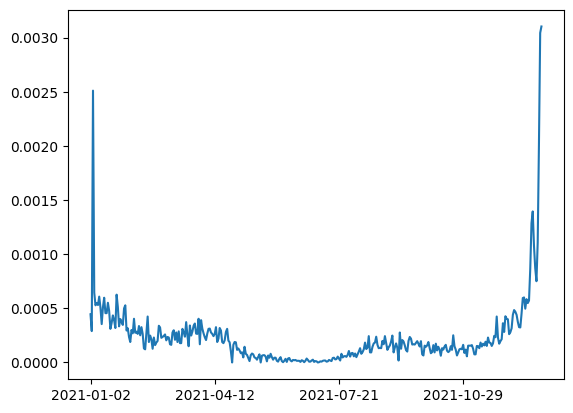

In [53]:
plt.plot(
    gdf[gdf.COUNTY == "MERCER"].date.iloc[1:],
    np.diff(gdf[gdf.COUNTY == "MERCER"].cases)
    / gdf[gdf.COUNTY == "MERCER"].pop2020.iloc[1:],
)
plt.xticks(plt.xticks()[0][::100]);

In [ ]:
county_id = (ro.r("as.factor")(gdf.COUNTY)).astype(float)
county_id_2 = county_id
time_id = (ro.r("as.factor")(gdf.date)).astype(float)

In [ ]:
g = rinla.inla_read_graph(adj)

In [584]:
formula1 = """
cases ~ f(county_id, model="bym", graph=g) + f(time_id, model="ar1") + poverty + income
"""

In [572]:
formula2 = """
cases ~ f(county_id, model="besag", graph=g) + f(time_id, model="rw2") + poverty + income
"""

In [587]:
formula3 = """
cases ~ 1 + f(county_id, model="besag", graph=g, group=time_id, control.group=list(model="ar1")) + 
    poverty + income
"""

In [544]:
diffcases = np.concatenate(
    gdf.groupby("COUNTY")
    .cases.apply(lambda x: np.concatenate(([0], np.diff(x))))
    .values
)

In [617]:
res = inla(
    formula=formula3,
    family="poisson",
    data=dict(
        cases=diffcases,
        county_id=county_id,
        county_id_2=county_id,
        time_id=time_id,
        time_id_2=time_id,
        poverty=gdf.poverty2021 / gdf.pop2021,
        income=gdf.income2021 / 1_000,
        g=g,
    ),
    E=gdf.pop2021,
    control_predictor=dict(compute=True),
    control_compute=dict(config=True, return_marginals_predictor=True),
    # control_mode=dict(result=res.result),
).improve_hyperpar()

GMRFLib_2order_approx: rescue NAN/INF values in logl for idx=1824
R[write to console]: Error in inla.inlaprogram.has.crashed() : 
  The inla-program exited with an error. Unless you interupted it yourself, please rerun with verbose=TRUE and check the output carefully.
  If this does not help, please contact the developers at <help@r-inla.org>.




 *** inla.core.safe:  inla.program has crashed: rerun to get better initial values. try=1/2 


R[write to console]: 



RRuntimeError: Error in inla.inlaprogram.has.crashed() : 
  The inla-program exited with an error. Unless you interupted it yourself, please rerun with verbose=TRUE and check the output carefully.
  If this does not help, please contact the developers at <help@r-inla.org>.


In [594]:
res

Time used:
     = 1.9,  = 0.362,  = 0.141,  = 2.41 
Fixed effects:
               mean    sd 0.025quant 0.5quant 0.975quant    mode kld
(Intercept) -11.797 1.208    -14.180  -11.799     -9.400 -11.803   0
poverty      10.789 4.926      1.002   10.801     20.502  10.823   0
income        0.028 0.011      0.007    0.028      0.049   0.028   0

Random effects:
  Name	  Model
    county_id BYM model
   time_id AR1 model

Model hyperparameters:
                                                mean       sd 0.025quant
Precision for county_id (iid component)     3195.291 4576.737    230.674
Precision for county_id (spatial component)    1.212    0.387      0.599
Precision for time_id                          0.602    0.147      0.351
Rho for time_id                                0.902    0.024      0.849
                                            0.5quant 0.975quant    mode
Precision for county_id (iid component)     1829.171   1.45e+04 600.523
Precision for county_id (spatial component)    

<AxesSubplot: >

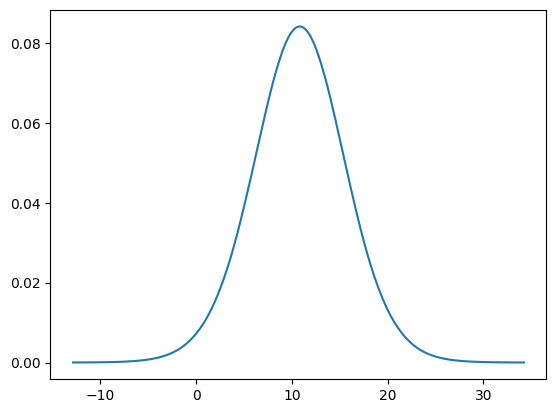

In [595]:
res.get_marginal_type("fixed").get_marginal("poverty").spline().plot()

In [596]:
rr_mode = res.get_summary("fitted.values")["mode"]

<AxesSubplot: >

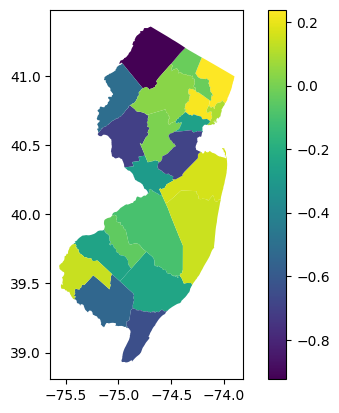

In [597]:
gdf[::365].plot(
    np.log10(rr_mode[::365] * gdf.pop2021[::365]),
    legend=1,
)

(-700.0, 700.0)

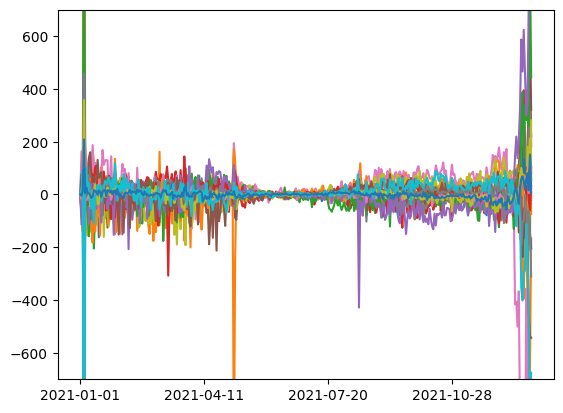

In [598]:
for i in range(21):
    plt.plot(
        gdf.date[:365],
        rr_mode[i * 365 : (i + 1) * 365] * gdf.pop2021[i * 365 : (i + 1) * 365]
        - diffcases[i * 365 : (i + 1) * 365],
    )
plt.xticks(plt.xticks()[0][::100])
plt.ylim(-700, 700)

In [604]:
min(np.log(rr_mode[:] * gdf.pop2021[:]))

-2.1285875172746276

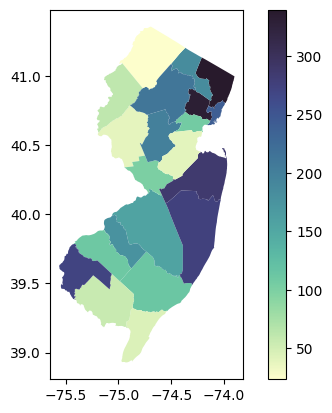

In [606]:
i = 100
ax = gdf[i::365].plot(
    rr_mode[i::365] * gdf.pop2021[i::365],
    legend=1,
    # norm=plt.Normalize(-2.1, 8.5),
    cmap=cmo.deep,
)

In [610]:
for i in tqdm(range(364)):
    ax = gdf[i::365].plot(
        rr_mode[i::365] * gdf.pop2021[i::365],
        legend=1,
        norm=plt.Normalize(0, 500),
        cmap=cmo.deep,
    )
    ax.axis("off")
    ax.set_title(f"{np.unique(gdf.date)[i]}")
    fig = ax.get_figure()
    fig.savefig(f"./out/inlapred-{str(i).zfill(3)}.jpg", dpi=300)
    plt.close()

  0%|          | 0/364 [00:00<?, ?it/s]

In [611]:
!ffmpeg -y -framerate 30 -pattern_type glob -i 'out/inlapred*.jpg' -c:v libx264 -pix_fmt yuv420p out/inlapred.mp4

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.202)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/5.1.2_6 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack

In [612]:
Video("./out/inlapred.mp4", width=500, height=600)

In [613]:
for i in tqdm(range(364)):
    ax = gdf[i::365].plot(
        (rr_mode[i::365] * gdf.pop2021[i::365] - diffcases[i::365]) / diffcases[i::365],
        legend=1,
        norm=plt.Normalize(-0.2, 0.2),
        vmin=-0.1,
        vmax=0.1,
        cmap="RdBu",
    )
    ax.axis("off")
    ax.set_title(f"{np.unique(gdf.date)[i]}")
    fig = ax.get_figure()
    fig.savefig(f"./out/inlares-{str(i).zfill(3)}.jpg", dpi=300)
    plt.close()

  0%|          | 0/364 [00:00<?, ?it/s]

In [614]:
!ffmpeg -y -framerate 30 -pattern_type glob -i 'out/inlares*.jpg' -c:v libx264 -pix_fmt yuv420p out/inlares.mp4

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.202)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/5.1.2_6 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack

In [615]:
Video("./out/inlares.mp4", width=500, height=600)